# Investment Assignment 
_Submitted by Muraleedharan Subramanian_ 
<hr>

- bullet points marked in <font color="blue"> __blue__ </font> are followed by code for answers required in spreadsheet
<br><br>
- Load csv files to dataframes (assuming files will be in the notebook directory)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


companies = pd.read_csv('companies.csv',encoding = "ISO-8859-1")
rounds2 = pd.read_csv('rounds2.csv',encoding = "ISO-8859-1")

- Describe companies dataframe to insect the data frame

In [3]:
companies.describe()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,66368,66367,61310,63220,66368,59410,57821,58338,58340,51147
unique,66368,66099,61191,27296,4,137,311,1092,5111,3978
top,/Organization/Nom,Roost,http://www.askforoffer.com,Software,operating,USA,CA,SF Bay Area,San Francisco,01-01-2012
freq,1,4,5,3995,53034,37601,12900,8804,3526,2730


permalink column is unique in every row (count=unique), hence we will use it as the key for companies.<br>
Now lets get all unique values by dropping invalid values, and converting the key column to lower - just to be safe.<br>
- <font color=blue>__Number of unique companies present in companies dataframe__</font>

In [4]:
companies["permalink"]=companies["permalink"].str.lower()
unique_value_companies = companies["permalink"].nunique(dropna = True) 
print(unique_value_companies)

66368


- Head() of rounds2 dataframe to get the columns and sample data

In [5]:
rounds2.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,01-03-2014,700000.0
3,/ORGANIZATION/-THE-ONE-OF-THEM-INC-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0


- Describe to see which column is unique key here (count=unique)


In [6]:
rounds2.loc[:,["company_permalink","funding_round_permalink"]].describe()

,company_permalink,funding_round_permalink
count,114949,114949
unique,90247,114949
top,/ORGANIZATION/SOLARFLARE,/funding-round/25a17c61849a577c012eb14f716111a2
freq,10,1


Convert company_permalink to lower case and use nunique() to get<br>
- <font color=blue>__Unique companies in rounds2 dataframe__</font>

In [7]:
rounds2["company_permalink"]=rounds2["company_permalink"].str.lower()
unique_value_rounds2 = rounds2["company_permalink"].nunique(dropna = True) 
print(unique_value_rounds2)

66370


To check if we have companies that are present only in rounds2 dataframe <br>
- Using a left outer join to create master frame with indicator column. <br>
- If we see indicator column with left-only they are present only in rounds2 <br>

From the output we can see there are a few with special cahareters in permalink,<br>
but there is one company that seem to have a proper name, present only in rounds2

In [8]:
master_frame = pd.merge(rounds2,companies,left_on="company_permalink",right_on="permalink",how="left",indicator=True)
master_frame.loc[master_frame["_merge"]!="both"][["company_permalink","_merge"]]

,company_permalink,_merge
29597,/organization/e-cãbica,left_only
31863,/organization/energystone-games-çµç³æ¸¸æ,left_only
45176,/organization/huizuche-com-æ ç§ÿè½¦,left_only
58473,/organization/magnet-tech-ç£ç³ç§æ,left_only
101036,/organization/tipcat-interactive-æ²èÿä¿¡æ¯ç...,left_only
109969,/organization/weiche-tech-åè½¦ç§æ,left_only
113839,/organization/zengame-ç¦ æ¸¸ç§æ,left_only


Merge _rounds2_ and _companies_ dataframe to _master_frame_ dataframe.<br>
Using inner join to avoid invalid values for company details.

In [9]:
master_frame = pd.merge(rounds2,companies,left_on="company_permalink",right_on="permalink",how="inner")

master_frame["company_permalink"].describe()

count                       114942
unique                       66363
top       /organization/solarflare
freq                            19
Name: company_permalink, dtype: object

- <font color=blue>__Number of Observations in master_frame__</font>

In [10]:
print(len(master_frame))

114942


- Clean data in master frame
 - raised_amount_usd == null will not be useful 
 - if country code is not available, drop those rows
 - Without category list, we can't make any useful ineferences
 - if raised_amount_usd is zero, it could be an error, not useful for analysis

In [11]:
master_frame=master_frame.loc[pd.notnull(master_frame["raised_amount_usd"])]
master_frame=master_frame.loc[pd.notnull(master_frame["country_code"])]
master_frame=master_frame.loc[pd.notnull(master_frame["category_list"])]
master_frame=master_frame.loc[master_frame["raised_amount_usd"]!=0]

#Convert the raised amount to millions for easy readability
master_frame["raised_amount_usd"]=master_frame["raised_amount_usd"]/1000000

- Assumption: We need to look into only the 4 funding types of interest <br>
    angel, venture, seed & private_equity
- Even if some companies recieved other type of funding, not using for this analysis

In [12]:

master_frame = master_frame.loc[master_frame["funding_round_type"].isin(["angel","venture","seed","private_equity"])]

- Group by funding type and describe to see the stats for each funding type

In [13]:
master_frame.groupby("funding_round_type").describe()

raised_amount_usd                                   \
                               count       mean         std       min   
funding_round_type                                                      
angel                         4373.0   0.977573    7.734298  0.000012   
private_equity                1819.0  73.979134  201.824500  0.001660   
seed                         21024.0   0.750319    2.291765  0.000001   
venture                      47786.0  11.729866   88.236566  0.000001   

                                                              
                        25%     50%        75%           max  
funding_round_type                                            
angel               0.15962   0.425   1.000000    494.511992  
private_equity      5.00000  20.000  75.762572   4745.460219  
seed                0.07000   0.300   1.000000    200.000000  
venture             1.60000   5.000  12.000000  17600.000000

- Use plots to determine the best representative value for the 4 investment types of interest
venture, seed, private_equity & angel

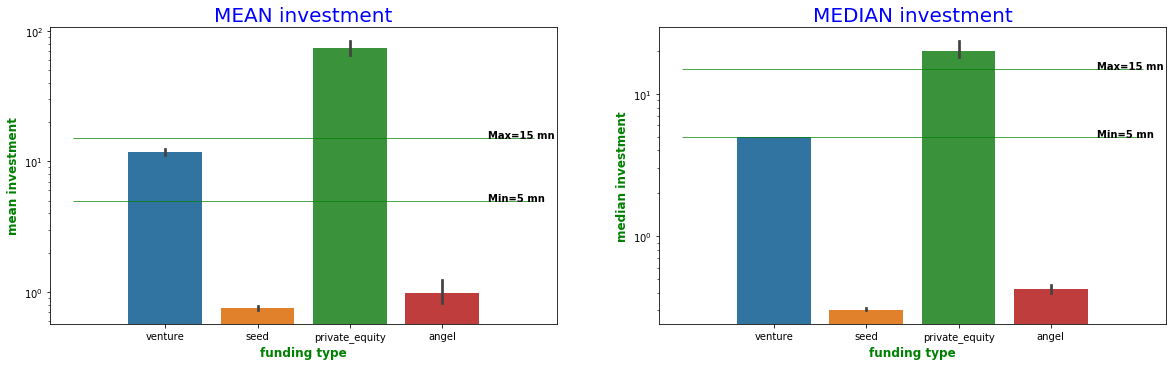

In [14]:
from numpy import mean,median
plt.figure(num=1,figsize=(20,12))
plt.subplot(221)

chart=sns.barplot(x="funding_round_type",y="raised_amount_usd", data=master_frame, estimator=mean)
plt.yscale("log")
chart.set_title("MEAN investment",fontsize=20, color="blue")
chart.axes.hlines( y = 15, color='green', linewidth=1, alpha=.7, 
                         xmin = -1, xmax = 4, label="mean1") 
chart.axes.hlines( y = 5, color='green', linewidth=1, alpha=.7, 
                         xmin = -1, xmax = 4, label="mean2") 
chart.set_xlabel("funding type", fontsize=12,color="green", weight="bold")
chart.set_ylabel("mean investment", fontsize=12,color="green", weight="bold")

plt.text(x=3.5,y=5,s="Min=5 mn",fontsize=10,weight="bold")
plt.text(x=3.5,y=15,s="Max=15 mn",fontsize=10,weight="bold")
plt.subplot(222)
chart2=sns.barplot(x="funding_round_type",y="raised_amount_usd", data=master_frame, estimator=median)
plt.yscale("log")
plt.text(x=3.5,y=5,s="Min=5 mn",fontsize=10,weight="bold")
plt.text(x=3.5,y=15,s="Max=15 mn",fontsize=10,weight="bold")
chart2.set_title("MEDIAN investment",fontsize=20, color="blue")
chart2.axes.hlines( y = 15, color='green', linewidth=1, alpha=.7, 
                         xmin = -1, xmax = 4, label="median1") 
chart2.axes.hlines( y = 5, color='green', linewidth=1, alpha=.7, 
                         xmin = -1, xmax = 4, label="median2") 
chart2.set_xlabel("funding type", fontsize=12,color="green", weight="bold")
chart2.set_ylabel("median investment", fontsize=12,color="green", weight="bold")
plt.show()

- From the plots above it is clear regardless of whether we consider mean or median<br>
  __only venture type funding seem to fit our criteria of 5 million to 15 million range__
  
- Another plot to check which type pf funding is more popular by count

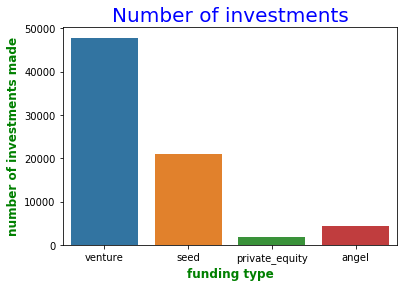

In [15]:
chart3 = sns.countplot(x="funding_round_type", data=master_frame)
chart3.set_title("Number of investments",fontsize=20, color="blue")
chart3.set_xlabel("funding type", fontsize=12,color="green", weight="bold")
chart3.set_ylabel("number of investments made", fontsize=12,color="green", weight="bold")

plt.show()

- Venture seem to be the popular one in terms of number of investments.

Let's get the answers for representative numbers for each investment type<br>
Going with mean as we saw from plots that final outcome is same regardless of which statistic we pick.
- <font color=blue>__Average values of investments for each funding type (in millions)__</font>

In [16]:
master_frame.groupby("funding_round_type").mean()

,raised_amount_usd
funding_round_type,
angel,0.977573
private_equity,73.979134
seed,0.750319
venture,11.729866


 - __Get country codes for english speaking countries from wikipedia__

In [17]:
import requests
from lxml import etree
wiki_url = requests.get("https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language").text

# Convert the text to a tree structure
html = etree.HTML(wiki_url)

# Get all 'tr' (rows from tables in this page), headers are tagged <th> hence will not be picked
tr_nodes = html.xpath('//table/tbody/tr')

# Get text from columns tagged <td>
td_content = [[td.text for td in tr.xpath('td')] for tr in tr_nodes[:]]

# Get country codes from the first two tables that has > 5 columns
# Others doesn't have country code, rtsrip to remove newline 
country_codes = [td[2].rstrip() for td in td_content[1:] if len(td) > 5]
        
# convert to a pandas dataframe so that we could do a join with master_frame
ccode = pd.DataFrame(country_codes)
ccode.columns = ["country_code"]


- Join with master_frame for english speaking countries 

In [18]:
master_frame = pd.merge(master_frame,ccode,on="country_code",how="inner")

- Get a list of top countries based on total investments made across all four investment types

In [19]:
top_countries = master_frame.groupby("country_code").sum().sort_values(by="raised_amount_usd",ascending=False)[:9]
top_countries.head(9)
top_countries.index

Index(['USA', 'GBR', 'IND', 'CAN', 'SGP', 'IRL', 'AUS', 'GRD', 'ZAF'], dtype='object', name='country_code')

- <font color=blue>__Top 3 English speaking countries__</font>

In [20]:
print(top_countries.index[0])
print(top_countries.index[1])
print(top_countries.index[2])

USA
GBR
IND


- Filter master_frame to contain data only for top9 countries and create __top9__ dataframe

In [21]:
top9=master_frame.loc[master_frame["country_code"].isin(top_countries.index)]

- Since we have selected venture funding type for analysis, remove rows for all other funding types

In [22]:
top9=top9.loc[top9["funding_round_type"]=="venture"]

top9.describe()

,raised_amount_usd
count,40700.000000
mean,11.545467
std,94.338356
min,0.000001
25%,1.600000
50%,5.000000
75%,12.000000
max,17600.000000


- we need to map sectors to main sectors as given in mapping.csv, create a dataframe for mapping

In [23]:
mapping = pd.read_csv("mapping.csv", encoding = "ISO-8859-1")
mapping.head()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


- We need to convert this to name to name mapping for joining with top9 dataframe

In [24]:
mapping=pd.melt(mapping, id_vars=['category_list'], value_vars=list(mapping.columns)[1:])
mapping.rename(columns={"category_list":"primary_sector","variable": "main_sector"}, inplace=True,errors="raise")
mapping.loc[mapping["primary_sector"]=="3D"]

,primary_sector,main_sector,value
1,3D,Automotive & Sports,0
689,3D,Blanks,0
1377,3D,Cleantech / Semiconductors,0
2065,3D,Entertainment,0
2753,3D,Health,0
3441,3D,Manufacturing,1
4129,3D,"News, Search and Messaging",0
4817,3D,Others,0
5505,3D,"Social, Finance, Analytics, Advertising",0


- From the example of "3D" above, value = 0 are rows we don't need

In [25]:
mapping=mapping.loc[mapping["value"]!=0]

- We don't need value column anymore

In [26]:
mapping.drop("value",axis="columns",inplace=True)

In [27]:
mapping["primary_sector"]=mapping["primary_sector"].str.lower()
mapping["main_sector"]=mapping["main_sector"].str.lower()
mapping.head()

,primary_sector,main_sector
8,adventure travel,automotive & sports
14,aerospace,automotive & sports
45,auto,automotive & sports
46,automated kiosk,automotive & sports
47,automotive,automotive & sports


- Get primary_sector from category_list column in top9 dataframe
  first value in category_list is the primary_sector

In [28]:
top9["primary_sector"]=top9["category_list"].str.split("|",1).str[0].str.lower()
top9.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,primary_sector
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10.000000,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,media
1,/organization/21diamonds-india,/funding-round/6de7ffef8091ba9f33821f4b861f434a,venture,C,15-11-2012,6.369507,/organization/21diamonds-india,21Diamonds,http://www.21diamonds.de,E-Commerce,operating,IND,10,New Delhi,Gurgaon,01-06-2012,e-commerce
2,/organization/247-learning-private,/funding-round/4cd5cd165bc869bc40705a9e4b626bee,venture,NaN,06-11-2007,4.000000,/organization/247-learning-private,24x7 Learning,http://www.24x7learning.com,EdTech|Education|Systems,operating,IND,19,Bangalore,Bangalore,01-01-2001,edtech
4,/organization/3dsoc,/funding-round/bbedf1410fddeed341018583bbd0ca1e,venture,A,01-12-2007,1.240000,/organization/3dsoc,3DSoC,http://www.3dsoc.com,3D|Mobile,operating,IND,19,Bangalore,Bangalore,01-06-2006,3d
5,/organization/3dsoc,/funding-round/da8918e533a7caf0df0dc8d3f506c0f8,venture,B,01-08-2010,0.825000,/organization/3dsoc,3DSoC,http://www.3dsoc.com,3D|Mobile,operating,IND,19,Bangalore,Bangalore,01-06-2006,3d


- Join with mapping dataframe to get main_sector mapped for each row

In [29]:
top9 = pd.merge(top9,mapping,on="primary_sector",how="inner")
top9.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,primary_sector,main_sector
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10.00,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,media,entertainment
1,/organization/manas-informatics,/funding-round/719e50301803d3918ffa558fc877e41c,venture,NaN,02-02-2008,0.16,/organization/manas-informatics,Manas Informatic,http://www.topnews.in,Media|News,operating,IND,23,Mohali,Mohali,05-05-2007,media,entertainment
2,/organization/all-def-digital,/funding-round/452a2342fe720285c3b92e9bd927d9ba,venture,A,06-08-2014,5.00,/organization/all-def-digital,All Def Digital,http://alldefdigital.com,Media,operating,USA,CA,Los Angeles,Los Angeles,NaN,media,entertainment
3,/organization/audiosocket,/funding-round/0959f59e3a89bc8db8c6ed9c646349fd,venture,NaN,02-05-2013,0.65,/organization/audiosocket,Audiosocket,http://audiosocket.com,Media|Music|Technology,operating,USA,WA,Seattle,Seattle,01-05-2008,media,entertainment
4,/organization/audiosocket,/funding-round/4e3a53eec6c609943df752206070b23f,venture,A,02-09-2009,0.75,/organization/audiosocket,Audiosocket,http://audiosocket.com,Media|Music|Technology,operating,USA,WA,Seattle,Seattle,01-05-2008,media,entertainment


- Create D1, D2, D3 with data for top 3 countires 

In [30]:
D1 = top9.loc[(top9["country_code"]==top_countries.index[0]) & (top9["raised_amount_usd"] >= 5) & (top9["raised_amount_usd"] <= 15)]
D2 = top9.loc[(top9["country_code"]==top_countries.index[1]) & (top9["raised_amount_usd"] >= 5) & (top9["raised_amount_usd"] <= 15)]
D3 = top9.loc[(top9["country_code"]==top_countries.index[2]) & (top9["raised_amount_usd"] >= 5) & (top9["raised_amount_usd"] <= 15)]

# Add sum/count of investments grouped on main sector as separate columns
def add_aggregate_cols(df):
    dsum=df.groupby('main_sector')["raised_amount_usd"].sum().reset_index().rename(columns={"raised_amount_usd":"sum_invested"})
    dcount=df.groupby('main_sector')["permalink"].count().reset_index().rename(columns={"permalink":"count_invested"})
    df=pd.merge(df,dsum, on="main_sector", how="inner")
    df=pd.merge(df,dcount, on="main_sector", how="inner")
    return(df)

D1=add_aggregate_cols(D1)
D2=add_aggregate_cols(D2)
D3=add_aggregate_cols(D3)

In [31]:
D1["country_code"].describe()

count     11149
unique        1
top         USA
freq      11149
Name: country_code, dtype: object

In [32]:
D2["country_code"].describe()

count     577
unique      1
top       GBR
freq      577
Name: country_code, dtype: object

In [33]:
D3["country_code"].describe()

count     299
unique      1
top       IND
freq      299
Name: country_code, dtype: object

- <font color=blue>__Total number of investments (count)__</font>

In [35]:
print("USA: ", len(D1), "\nGBR: ", len(D2), "\nIND: ", len(D3))

USA:  11149 
GBR:  577 
IND:  299


- <font color=blue>__Total amount of investments (USD in millions)__</font>

In [36]:
print("USA: ", round(D1["raised_amount_usd"].sum()*1000000,0), 
      "\nGBR: ", round(D2["raised_amount_usd"].sum()*1000000,0), 
      "\nIND: ", round(D3["raised_amount_usd"].sum()*1000000,0))

USA:  99661524549.0 
GBR:  5028704358.0 
IND:  2683537552.0


- <font color=blue>__Top sector (based on count of investments)__</font>

In [37]:
D1sects=D1.groupby("main_sector").count().sort_values(by="permalink", ascending=False)
D2sects=D2.groupby("main_sector").count().sort_values(by="permalink", ascending=False)
D3sects=D3.groupby("main_sector").count().sort_values(by="permalink", ascending=False)
print("USA: ", D1sects.index[0], "\nGBR: ", D2sects.index[0], "\nIND: ", D3sects.index[0])

USA:  others 
GBR:  others 
IND:  others


- <font color=blue>__Second-best sector (based on count of investments)__</font>

In [38]:
print("USA: ", D1sects.index[1], "\nGBR: ", D2sects.index[1], "\nIND: ", D3sects.index[1])

USA:  cleantech / semiconductors 
GBR:  cleantech / semiconductors 
IND:  news, search and messaging


- <font color=blue>__Third-best sector (based on count of investments)__</font>

In [39]:
print("USA: ", D1sects.index[2], "\nGBR: ", D2sects.index[2], "\nIND: ", D3sects.index[2])

USA:  social, finance, analytics, advertising 
GBR:  social, finance, analytics, advertising 
IND:  entertainment


- <font color=blue>__Number of investments in the top sector__</font>

In [40]:

print("USA: ", D1sects.reset_index()["permalink"][0], 
      "\nGBR: ", D2sects.reset_index()["permalink"][0], 
      "\nIND: ", D3sects.reset_index()["permalink"][0])

USA:  2923 
GBR:  143 
IND:  109


- <font color=blue>__Number of investments in the second-best sector__</font>

In [41]:

print("USA: ", D1sects.reset_index()["permalink"][1], 
      "\nGBR: ", D2sects.reset_index()["permalink"][1], 
      "\nIND: ", D3sects.reset_index()["permalink"][1])

USA:  2297 
GBR:  127 
IND:  52


- <font color=blue>__Number of investments in the third-best sector__</font>

In [42]:

print("USA: ", D1sects.reset_index()["permalink"][2], 
      "\nGBR: ", D2sects.reset_index()["permalink"][2], 
      "\nIND: ", D3sects.reset_index()["permalink"][2])

USA:  1912 
GBR:  98 
IND:  33


- <font color=blue>__For the top sector count-wise (point 3), which company received the highest investment__</font>

In [56]:
# params: dataframe, sector name, position (top nth)
# This function will return top nth company of a given sector
def getmaxcompany(df,sector,pos):
    
    # get the sector, group by permalink & name (since we need company name)
    dcompany=df.loc[df["main_sector"]==sector].groupby(["permalink","name"]).count().reset_index()
    
    # Filter out top n-1 
    for i in range(1,pos):
        dmax=dcompany["company_permalink"].max()
        dcompany=dcompany.loc[dcompany["company_permalink"]!=dmax]
    
    # return the current top companies
    dmax=dcompany["company_permalink"].max()
    return(dcompany.loc[dcompany["company_permalink"]==dmax].name.to_list())

print("USA:\n", getmaxcompany(D1,"others",1))

print("GBR:\n", getmaxcompany(D2,"others",1))

print("IND:\n", getmaxcompany(D3,"others",1))

USA:
 ['Black Duck Software', 'Capella Photonics', 'Virtustream']
GBR:
 ['Electric Cloud', 'SenSage']
IND:
 ['Myntra']


- <font color=blue>__For the second-best sector count-wise (point 4), which company received the highest investment?__</font>

In [44]:
print("USA:\n", getmaxcompany(D1,"cleantech / semiconductors",1))

print("GBR:\n", getmaxcompany(D2,"cleantech / semiconductors",1))

print("IND:\n", getmaxcompany(D3,"news, search and messaging",1))

USA:
 ['Biodesix', 'Tigo Energy']
GBR:
 ['EUSA Pharma', 'F-star Biotechnology Limited', 'Horizon Discovery']
IND:
 ['GupShup']


- Define a function for creating similar plots

In [45]:
# params: 
# figure number, dataframe, x-value name, y-value name, chart title, x axis title, y axis title, if log scale to be used

def plotit(fign, df, xval,yval, title, xtitle, ytitle, yscale):
    plt.figure(num=fign, figsize=(20,12))
    plot1 = sns.barplot(x=xval, y=yval, data=df)
    plot1.set_title(title,fontsize=20, color="blue")
    plot1.set_xlabel(xtitle, fontsize=12,color="green", weight="bold")
    plot1.set_ylabel(ytitle, fontsize=12,color="green", weight="bold")
    for index, row in df.iterrows():
        plot1.text(row.name,row.raised_amount_usd, round(row.raised_amount_usd,2), color='black', ha="center",
                    fontsize=14, weight="bold")


    if yscale:
        plt.yscale("log")
    plt.show()

- <font color=blue>__Plots required for Spark Funds LLC CEO__</font>

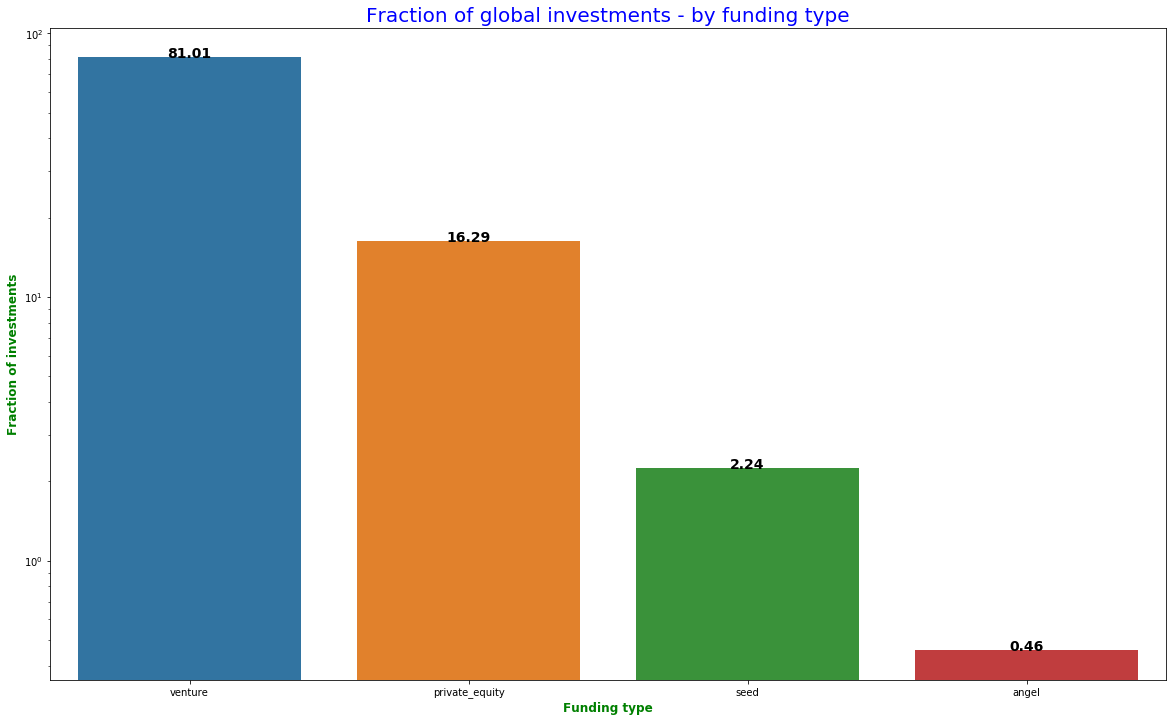

,funding_round_type,raised_amount_usd
0,venture,81.012301
1,private_equity,16.286996
2,seed,2.242313
3,angel,0.458390


In [46]:
total_invest = master_frame["raised_amount_usd"].sum()
fundtype = master_frame.loc[master_frame["funding_round_type"].isin(["venture","angel","seed","private_equity"])]
fundtype = fundtype.groupby("funding_round_type").sum()/total_invest*100
fundtype = fundtype.sort_values(by="raised_amount_usd", ascending=False)
fundtype.reset_index(inplace=True)

plt.show()
plotit(5,fundtype, "funding_round_type", "raised_amount_usd",
      "Fraction of global investments - by funding type",
      "Funding type", "Fraction of investments",
      True)
fundtype.head()

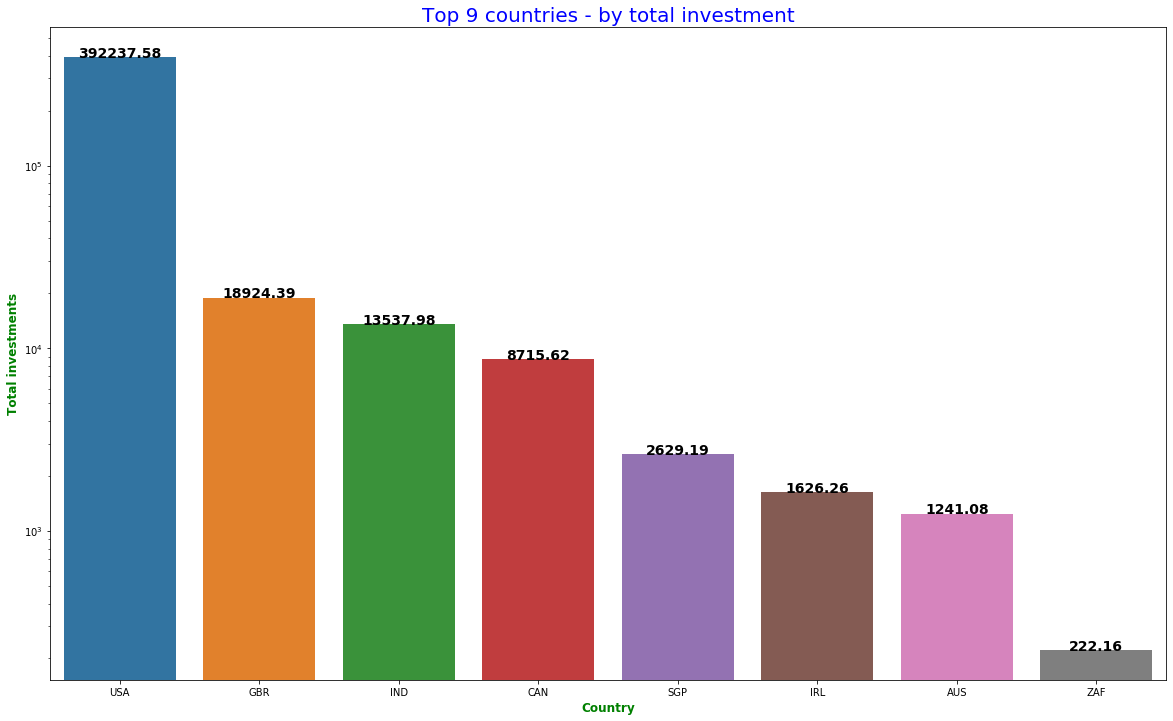

,country_code,raised_amount_usd
0,USA,392237.581395
1,GBR,18924.390319
2,IND,13537.981235
3,CAN,8715.620524
4,SGP,2629.189456
5,IRL,1626.264771
6,AUS,1241.084375
7,ZAF,222.163106


In [47]:
top9_invested = top9.groupby("country_code").sum()
top9_invested = top9_invested.sort_values(by="raised_amount_usd",ascending=False)
top9_invested.reset_index(inplace=True)
plotit(6,top9_invested, "country_code", "raised_amount_usd",
      "Top 9 countries - by total investment",
      "Country", "Total investments",
      True)
top9_invested.loc[:,["country_code","raised_amount_usd"]]

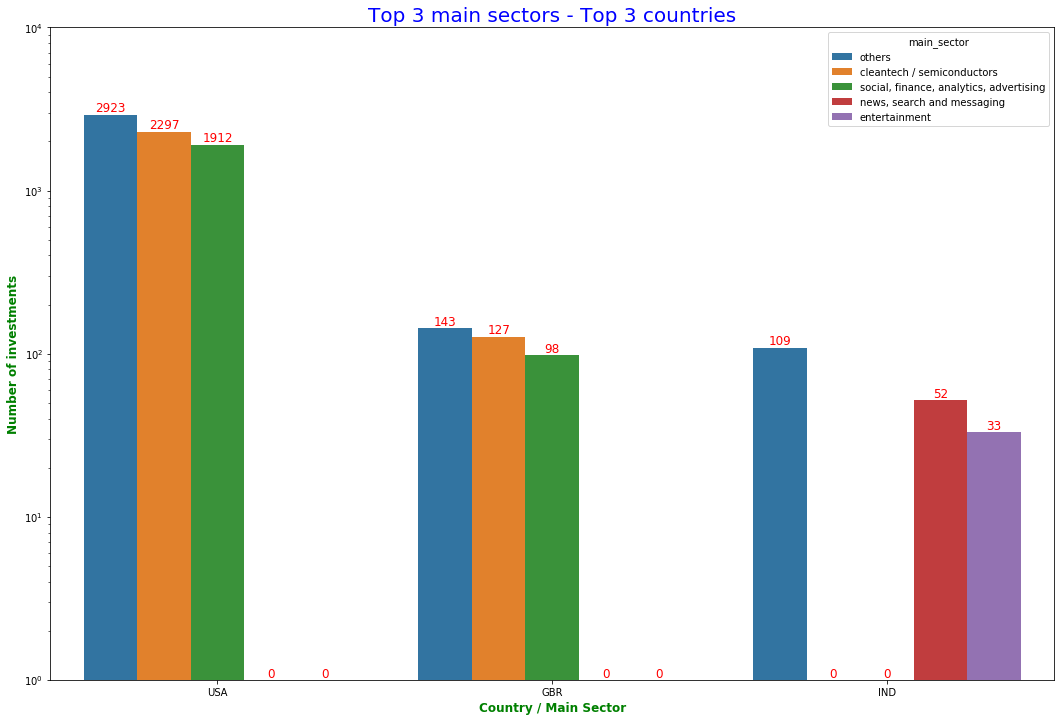

,country_code,main_sector,permalink
0,USA,others,2923
1,USA,cleantech / semiconductors,2297
2,USA,"social, finance, analytics, advertising",1912
3,GBR,others,143
4,GBR,cleantech / semiconductors,127
5,GBR,"social, finance, analytics, advertising",98
6,IND,others,109
7,IND,"news, search and messaging",52
8,IND,entertainment,33


In [52]:
from math import isnan

# Get top3 sectors from D1, D2 & D3 into top3
top3 = D1.groupby(["country_code","main_sector"]).count().reset_index().\
       sort_values(by="raised_amount_usd", ascending=False)[:3]
top3 = top3.append( D2.groupby(["country_code","main_sector"]).count().reset_index().\
       sort_values(by="raised_amount_usd", ascending=False)[:3],
           ignore_index=True)
top3 = top3.append(D3.groupby(["country_code","main_sector"]).count().reset_index().\
       sort_values(by="raised_amount_usd", ascending=False)[:3],
           ignore_index=True)
 
fig=plt.figure(num=9, figsize=(18,12))
sectwise = sns.barplot(x="country_code", y="raised_amount_usd", hue="main_sector",data=top3)
sectwise.set_title("Top 3 main sectors - Top 3 countries",fontsize=20, color="blue")
sectwise.set_xlabel("Country / Main Sector", fontsize=12,color="green", weight="bold")
sectwise.set_ylabel("Number of investments", fontsize=12,color="green", weight="bold")
plt.yscale("log")
ax = plt.gca()

# ylim max value to be set
ax.set_ylim((pow(10,0),pow(10,4)))
nanone = lambda x : 1 if isnan(x) else x
nanzero = lambda x : 0 if isnan(x) else x
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., nanone(p.get_height()), '%d' % int(nanzero(p.get_height())), 
            fontsize=12, color='red', ha='center', va='bottom')

#plt.yscale("log")

plt.show()
top3.loc[:,["country_code","main_sector","permalink"]]

- Since there are 5 different sectors in total, bar plot show blanks for sectors not present for the country. <br>
This seemed the best way to represent it visually, hence going with barplot/hue 